In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn import preprocessing

# import ghg data
dat = (
    pd.read_csv('data/new-zealands-greenhouse-gas-emissions-19902016.csv')
        .melt(id_vars=['Gas','Source'],
            var_name='Year', value_name='Units')
        .query('Gas == "All gases"')
        .astype({
            'Year': 'int32',
            'Gas': 'category',
            'Source': 'category'    
        })
        .pivot(index='Year', columns='Source', values='Units')
        .rename(columns={
            "All sources, Gross (excluding LULUCF)": "GrossUnits"
        })
        # set Year as variable rather than index
        .reset_index()
)

# import cars data
# source: http://infoshare.stats.govt.nz/
# Industry sectors --> Transport - TPT --> Motor Vehicles Currently Licensed by Type (Annual-Mar)
years = [str(i) for i in list(range(1990, 2017))] 
cars = (
    pd.read_csv('data/vehicle-regos.csv')
    .rename(columns={
        "Motor Vehicles Currently Licensed by Type (Annual-Mar)": "Year",
        "Unnamed: 1": "NumLicensedVehicles"
    })
    .query("Year.isin(@years)")
    .astype({
        "Year": "int32",
        "NumLicensedVehicles": "int32"
    })
)

# import agricultural data
# source: http://infoshare.stats.govt.nz/
# Industry sectors --> Agriculture - AGR --> Variable by Total New Zealand (Annual-Jun)
agr = (
    pd.read_csv('data/agr.csv').
    rename(columns={
        "Variable by Total New Zealand (Annual-Jun)": "Year",
        "Unnamed: 1": "NumDairyCattle",
    })
    .replace("..", np.NaN)
    .query("Year.isin(@years)")
)

# impute missing values
# (from 1997 to 2001, four out of five years have missing data)
imputer = KNNImputer(n_neighbors=2, weights="uniform")
agr = pd.DataFrame(imputer.fit_transform(agr),columns = agr.columns)

# import agricultural data
# source: http://infoshare.stats.govt.nz/
# Industry sectors --> Alcohol Available for Consumption --> Litres of Alcohol (Annual-Dec)
alcohol = (
    pd.read_csv('data/beer.csv')
    .rename(columns={
        "Litres of Alcohol (Annual-Dec)": "Year",
        "Unnamed: 1": "LitresOfAlcohol",
    })
    .query("Year.isin(@years)")
    .astype({
        "Year": "int32",
        "LitresOfAlcohol": "float"
    })
)

# join all data
dat = (
    dat.merge(
        cars, on='Year', how='left'
    )
    .merge(
        agr, on='Year', how='left'
    )
    .merge(
        alcohol, on='Year', how='left'
    )
)

# let's just take what we need
dat = dat.loc[:, ['Year', 'GrossUnits', 'NumLicensedVehicles', 'NumDairyCattle', 'LitresOfAlcohol']]

# what does it look like now?
dat.head()

,Year,GrossUnits,NumLicensedVehicles,NumDairyCattle,LitresOfAlcohol
0,1990,65814.79,2300231,3440815.0,15.443
1,1991,66735.96,2348410,3429427.0,14.655
2,1992,67936.08,2351868,3467824.0,14.625
3,1993,67465.28,2379417,3550140.0,14.084
4,1994,68635.51,2437515,3839184.0,14.232


In [ ]:
# center the explanatory variables!
dat.NumLicensedVehicles = dat.NumLicensedVehicles - dat.NumLicensedVehicles.mean()
dat.NumDairyCattle = dat.NumDairyCattle - dat.NumDairyCattle.mean()
dat.NumSheep = dat.NumSheep - dat.NumSheep.mean()
dat.LitresOfAlcohol = dat.LitresOfAlcohol - dat.LitresOfAlcohol.mean()

In [27]:
reg = smf.ols('GrossUnits ~ NumLicensedVehicles + LitresOfAlcohol + NumDairyCattle', data=dat).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             GrossUnits   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     21.49
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           7.32e-07
Time:                        20:03:14   Log-Likelihood:                -252.71
No. Observations:                  27   AIC:                             513.4
Df Residuals:                      23   BIC:                             518.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.005e+05   2

In [45]:
reg = smf.ols('GrossUnits ~ NumLicensedVehicles + LitresOfAlcohol', data=dat).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             GrossUnits   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     32.84
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           1.35e-07
Time:                        20:58:48   Log-Likelihood:                -252.95
No. Observations:                  27   AIC:                             511.9
Df Residuals:                      24   BIC:                             515.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            9.358e+04   1

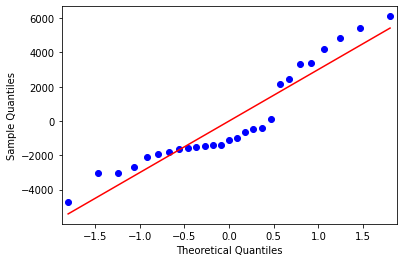

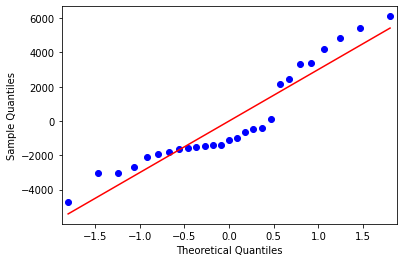

In [38]:
# Q-Q plot for normality
sm.qqplot(reg.resid, line='r')

Text(0.5, 0, 'Observation Number')

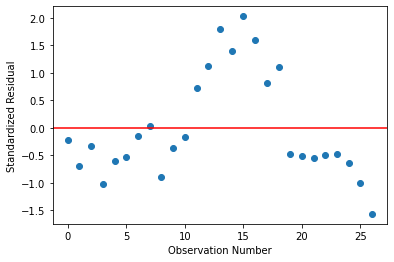

In [41]:
# residuals plot
stdres = pd.DataFrame(reg.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

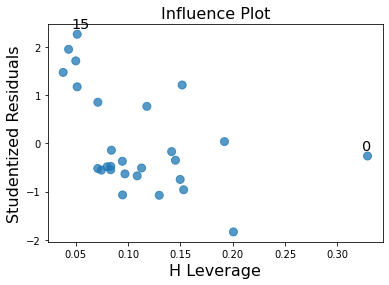

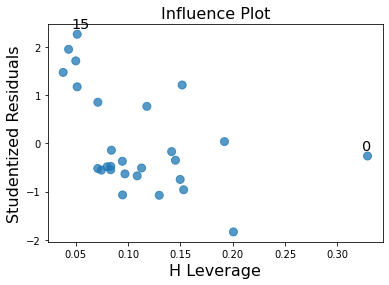

In [46]:
# leverage plot
sm.graphics.influence_plot(reg, size=8)

Text(0.5, 0, 'Observation Number')

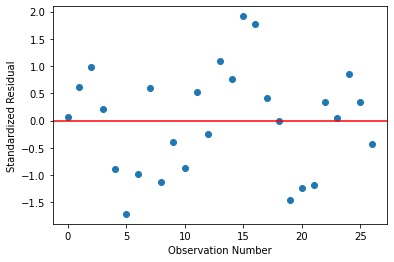

In [43]:
reg = smf.ols('GrossUnits ~ NumDairyCattle + I(NumDairyCattle**2)', data=dat).fit()
stdres = pd.DataFrame(reg.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

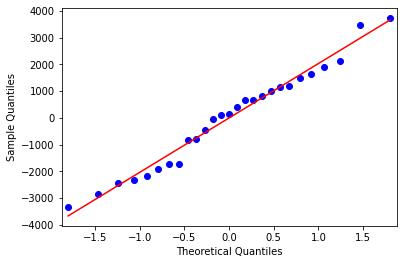

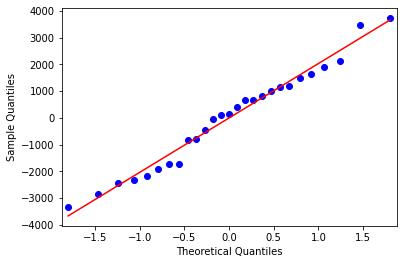

In [44]:
sm.qqplot(reg.resid, line='r')